In [146]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np


##  metrics

In [707]:
%cd '/home/ubuntu/project-phishing/src/'
import metrics as mm

/home/ubuntu/project-phishing/src


In [708]:
%cd '/home/ubuntu/project-phishing/src/keras-yolo3'

/home/ubuntu/project-phishing/src/keras-yolo3


For each file, load ground truth masks and predictions

In [665]:
img_list, bbox_list_true = mm.read_txt_file('data_test.txt')
img_list_pred, bbox_list_pred = mm.read_txt_file('output/data_pred.txt')

In [666]:
list(map(len, [img_list_pred, img_list, bbox_list_true, bbox_list_pred]))

[2583, 2583, 2583, 2583]

In [667]:
count_tpfpfn_from_bboxes(bbox_list_true, bbox_list_pred, conf_thr=0.5, iou_thr=0.5)

(4044, 647, 3539)

In [668]:
iou_thr_list = np.arange(0.1,0.91,0.1)
prec, rec = mm.prec_recalls_from_bboxes(bbox_list_true, bbox_list_pred, conf_thr_list = np.arange(0,1.01,0.01), iou_thr_list = iou_thr_list)
prec1, rec1 = mm.prec_recalls_from_bboxes(bbox_list_true, bbox_list_pred, conf_thr_list = np.arange(0.3,1.01,0.1), iou_thr_list = [0.5])


Mean Average Precision: iou_min = 0.1, mAP=0.62
Mean Average Precision: iou_min = 0.2, mAP=0.60
Mean Average Precision: iou_min = 0.3, mAP=0.59
Mean Average Precision: iou_min = 0.4, mAP=0.57
Mean Average Precision: iou_min = 0.5, mAP=0.54
Mean Average Precision: iou_min = 0.6, mAP=0.47
Mean Average Precision: iou_min = 0.7, mAP=0.31
Mean Average Precision: iou_min = 0.8, mAP=0.10
Mean Average Precision: iou_min = 0.9, mAP=0.00


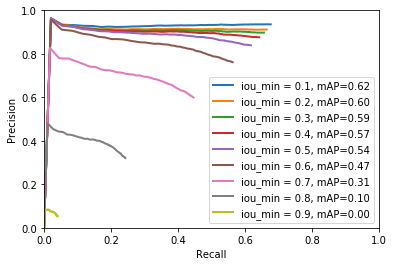

In [687]:
plt.gca().set(xlim=(0,1), ylim=(0,1), xlabel='Recall', ylabel='Precision')
for i in range(len(prec)):
    auc = np.trapz(prec[i], rec[i])
    lbl = 'IoU_min = {:.1f}, mAP={:.2f}'.format(iou_thr_list[i], auc)
    print('Mean Average Precision: {}'.format(lbl))
    plt.plot(rec[i], prec[i], label = lbl, lw=2)
#     plt.scatter(rec1[i], prec1[i])
plt.legend();

In [696]:
bb1 = bbox_list_true[0][0]
bb2 = bbox_list_pred[0][0]
bb1, bb2

([320, 288, 376, 348, 0], [327, 288, 372, 348, 0, 0.85847723])

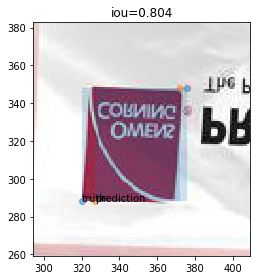

In [701]:
import matplotlib as mpl
plt.imshow(cv2.imread(img_list[0])[:,:,(2,1,0)])
for i, bb in enumerate([bb1, bb2]):
    plt.scatter([bb[0],bb[2]],[bb[1],bb[3]], alpha = 0.5)
    plt.gca().add_patch(mpl.patches.Rectangle((bb[0], bb[1]) ,bb[2]-bb[0], bb[3]-bb[1], alpha=0.2))
    plt.gca().annotate(['truth', 'prediction'][i], (bb[0],bb[1]))
plt.xlim(0.9*bb[0], 1.1*bb[2])
plt.ylim(0.9*bb[1], 1.1*bb[3])
plt.title('iou={:.3f}'.format(iou_from_bboxes(bb1,bb2)))
plt.gcf().tight_layout();

True positives: 23 - False Positives: 14, False Negatives: 26
Precision: 0.622 - Recall:0.469
... picking lower IoU threshold...
True positives: 30 - False Positives: 7 - False Negatives: 26
Precision: 0.811 - Recall:0.536


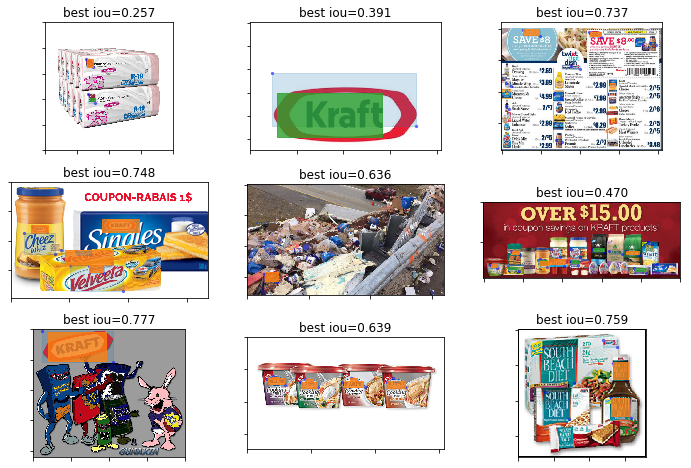

In [679]:
tp, fp, tpfp, fn = 0, 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            if j in match_dict[i]:
                continue
            iou = iou_from_bboxes(bb1, bb2)
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = k
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

True positives: 23 - False Positives: 14, False Negatives: 26
Precision: 0.622 - Recall:0.469


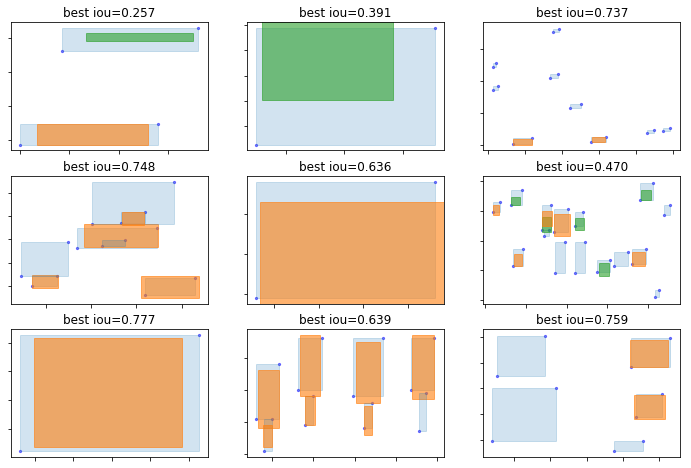

In [710]:
tp, fp, fn = 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            if j in match_dict[i]:
                continue
            iou = iou_from_bboxes(bb1, bb2)
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = k
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

Blue: True --- Yellow: predictions with IoU >= 0.5, Green: Predictions with IoU > 0.1

The dictionary holds the mapping between truth and predicted.    
For _each image index_, I have a mapping between **true boxes** and **matching predicted boxes**

To get the false negatives, pick the number of true boxes minus the number of matches

In [711]:
[(k, v, len(v)) for k,v in match_dict.items()]

[(0, {0: 0}, 1),
 (1, {}, 0),
 (2, {0: 0, 1: 1}, 2),
 (3, {0: 1, 1: 2, 2: 3, 4: 0}, 4),
 (4, {0: 0}, 1),
 (5, {0: 0, 2: 4, 4: 9, 6: 12, 11: 3}, 5),
 (6, {0: 0}, 1),
 (7, {0: 3, 1: 2, 2: 0, 3: 1, 4: 6, 5: 5, 6: 4}, 7),
 (8, {3: 0, 4: 1}, 2)]

If there are multiple predictions overlapping on the same ground truth, the previous algorithm picked the highest confidence. What happens if we pick the highest IoU?

True positives: 23 - False Positives: 14, False Negatives: 26
Precision: 0.622 - Recall:0.469


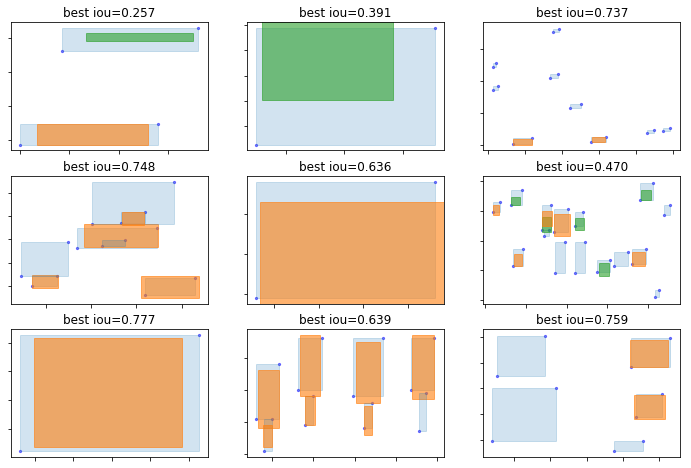

In [706]:
tp, fp, fn = 0, 0, 0
fig, axes = plt.subplots(3,3, figsize=(12,8))
match_dict = { i:{} for i in range(9)}
for i in range(9):#range(len(bbox_list_pred)):
    # axes[i//3, i%3].imshow(cv2.imread(img_list_pred[i])[:,:,(2,1,0)])
    for j, bb1 in enumerate(bbox_list_true[i]):
        axes[i//3, i%3].set(xticklabels='',yticklabels='')
        axes[i//3, i%3].scatter([bb1[0],bb1[2]],[bb1[1],bb1[3]], alpha = 0.5, c='b',s=5)
        axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb1[0], bb1[1]), 
            bb1[2]-bb1[0], bb1[3]-bb1[1], alpha=0.2, color=plt.get_cmap('tab10')(0)))
        for k, bb2 in enumerate(bbox_list_pred[i]):            
            
            iou = iou_from_bboxes(bb1, bb2)
            if j in match_dict[i] and match_dict[i][j][-1] > iou:
                # skip if already found other object with larger IoU
                continue
            if iou == 0:
                continue
            if iou > 0.5:
                tp += 1
                match_dict[i][j] = (k,iou)
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(1)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(iou_from_bboxes(bb1,bb2)))
            elif iou > 0.1:
                fp += 1
                axes[i//3, i%3].add_patch(mpl.patches.Rectangle((bb2[0], bb2[1]), 
                  bb2[2]-bb2[0], bb2[3]-bb2[1], alpha=0.6, color=plt.get_cmap('tab10')(2)))
                axes[i//3, i%3].set(title='best iou={:.3f}'.format(iou_from_bboxes(bb1,bb2)))
            else:
                fp += 1
    fn += len(bbox_list_true[i]) - len(match_dict[i])
print('True positives: {} - False Positives: {}, False Negatives: {}'.format(tp, fp, fn))
print('Precision: {:.3f} - Recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))